# Utilizando a biblioteca DARTS para forecasting
## Notebook desenvolvido para o curso Financial Analytics - Insper
Referências:
- https://unit8.com/resources/darts-time-series-made-easy-in-python/
- https://levelup.gitconnected.com/a-python-library-that-makes-it-simple-to-forecast-time-series-6a403da71542
- https://pypi.org/project/statsforecast/

### 1. Imports and data upload

In [1]:
#!pip install darts
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    TBATS,
    StatsForecastAutoARIMA
)

from darts import TimeSeries

import pmdarima as pmd
import pandas as pd
import numpy as np

In [2]:
# importing data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates = ['Month'],index_col = ['Month'])
series = TimeSeries.from_dataframe(df)

In [3]:
# split train and test
train, val = series.split_before(pd.Timestamp('19600101'))

### 2. Quick example on how to use DARTS

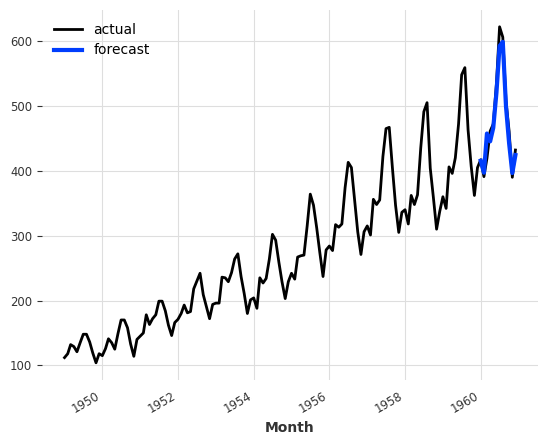

In [4]:
# training a Exponential Smoothing model and plotting prediction
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

import matplotlib.pyplot as plt

series.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

### 3. Testing for stationarity

In [5]:
# get order of first differencing: the higher of KPSS and ADF test results
y = np.asarray(series.pd_series())
ALPHA = 0.05
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
n_diff = max(n_adf, n_kpss)
print("number of diffences to get stationarity is = " + str(n_diff))

number of diffences to get stationarity is = 1


### 4. Algorithms setup

In [6]:
# setting the algorithm's hyparameters

m_expon = ExponentialSmoothing()

# prepare Prophet forecaster: multiplicative seas
m_prophet_m = Prophet(seasonality_mode="multiplicative")

# prepare Prophet forecaster: additive seas
m_prophet_a = Prophet(seasonality_mode="additive")

# prepare autoARIMA forecaster
m_autoarima = AutoARIMA(m=12, seasonal=True, trace = True, suppress_warnings=True)

# prepare autoARIMA from StatsForecast
m_autoarima_stats = StatsForecastAutoARIMA(season_length=12)

# prepare TBATS
m_tbats = TBATS(
        seasonal_periods=[12],
        use_arma_errors=True,  # shall try models with and without ARMA
        use_box_cox=True,  # will not use Box-Cox
        use_trend=True,  # will try models with trend and without it
        use_damped_trend=None,  # will try models with daming and without it
        show_warnings=False,  # will not be showing any warnings for chosen model
)


In [7]:
# list of models to be evaluated

models = [
    m_expon,
    m_prophet_m,
    m_prophet_a,
    m_autoarima,
    m_autoarima_stats,
    m_tbats]

### 5. Creating an evaluating function to run many models

In [8]:
## fit the chosen forecaster model and compute predictions

from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
import time

def eval_model(model, train, val):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # compute accuracy metrics and processing time
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy, res]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results

In [9]:
eval_model(m_autoarima, train, val)[1]

beginning: AutoARIMA(m=12, seasonal=True, trace=True, suppress_warnings=True)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=0.63 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.16 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.13 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.29 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.06 sec
 ARIMA(2,0,0)(0,1,1)[12] inter

{'MAPE': 3.097561557329857,
 'MAE': 14.89820850377221,
 'R squared': -0.9379723070639323,
 'RMSE': 18.536468974102828,
 'RMSLE': 0.03813972781160765,
 'time': 7.941131414998381}

In [10]:
eval_model(m_prophet_m, train, val)[1]

14:10:27 - cmdstanpy - INFO - Chain [1] start processing
14:10:27 - cmdstanpy - INFO - Chain [1] done processing


beginning: Prophet(seasonality_mode=multiplicative)
completed: Prophet(seasonality_mode=multiplicative):0.11695049199988716sec


{'MAPE': 4.453111789547509,
 'MAE': 21.956353216342663,
 'R squared': -0.8790866129617173,
 'RMSE': 25.88042404585697,
 'RMSLE': 0.05145454196131885,
 'time': 0.11695049199988716}

In [11]:
eval_model(m_autoarima_stats, train, val)[1]

beginning: StatsForecastAutoARIMA(season_length=12)
completed: StatsForecastAutoARIMA(season_length=12):9.333772078000038sec


{'MAPE': 4.187615474345368,
 'MAE': 18.550586776423433,
 'R squared': -0.8964057038105958,
 'RMSE': 23.955327718941057,
 'RMSLE': 0.05358015557856935,
 'time': 9.333772078000038}

In [12]:
eval_model(m_tbats, train, val)[1]

beginning: TBATS(use_box_cox=True, use_trend=True, seasonal_periods=[12])


completed: TBATS(use_box_cox=True, use_trend=True, seasonal_periods=[12]):14.279803273999278sec


{'MAPE': 3.363632873760305,
 'MAE': 15.296747006044919,
 'R squared': -0.9105661636546096,
 'RMSE': 22.257948067197432,
 'RMSLE': 0.04842364377418478,
 'time': 14.279803273999278}

Running all the models

In [13]:
# call the forecasters one after the other
model_predictions = [eval_model(model, train, val) for model in models]

14:11:05 - cmdstanpy - INFO - Chain [1] start processing
14:11:05 - cmdstanpy - INFO - Chain [1] done processing


beginning: ExponentialSmoothing()
completed: ExponentialSmoothing():0.10456465499737533sec
beginning: Prophet(seasonality_mode=multiplicative)
completed: Prophet(seasonality_mode=multiplicative):0.09652043499954743sec
beginning: Prophet(seasonality_mode=additive)


14:11:05 - cmdstanpy - INFO - Chain [1] start processing
14:11:05 - cmdstanpy - INFO - Chain [1] done processing


completed: Prophet(seasonality_mode=additive):0.0886409239974455sec
beginning: AutoARIMA(m=12, seasonal=True, trace=True, suppress_warnings=True)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.15 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=0.64 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.12 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.27 sec
 ARIMA(2,0,0)(0,1,0)[12] int

In [14]:
# RUN the forecasters and tabulate their prediction accuracy and processing time

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0:
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)


,ExponentialSmoothing(),Prophet(seasonality_mode=multiplicative),Prophet(seasonality_mode=additive),"AutoARIMA(m=12, seasonal=True, trace=True, suppress_warnings=True)",StatsForecastAutoARIMA(season_length=12),"TBATS(use_box_cox=True, use_trend=True, seasonal_periods=[12])"
MAPE,2.802824,4.453112,6.612082,3.097562,4.187615,3.363633
MAE,13.380462,21.956353,33.394932,14.898209,18.550587,15.296747
R squared,-0.947952,-0.879087,-0.666119,-0.937972,-0.896406,-0.910566
RMSE,16.979906,25.880424,43.006107,18.536469,23.955328,22.257948
RMSLE,0.035500,0.051455,0.081855,0.038140,0.053580,0.048424
time,0.104565,0.096520,0.088641,7.663588,0.389124,14.601522


### 6. Cross validation using DARTS

14:11:31 - cmdstanpy - INFO - Chain [1] start processing
14:11:31 - cmdstanpy - INFO - Chain [1] done processing
14:11:31 - cmdstanpy - INFO - Chain [1] start processing
14:11:31 - cmdstanpy - INFO - Chain [1] done processing
14:11:31 - cmdstanpy - INFO - Chain [1] start processing
14:11:31 - cmdstanpy - INFO - Chain [1] done processing
14:11:31 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1] done processing
14:11:32 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1] done processing
14:11:32 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1] done processing
14:11:32 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1] done processing
14:11:32 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1] done processing
14:11:32 - cmdstanpy - INFO - Chain [1] start processing
14:11:32 - cmdstanpy - INFO - Chain [1]

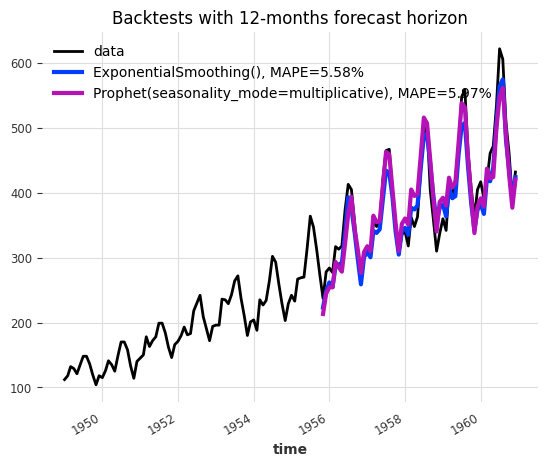

In [15]:
models_backtest = [m_expon, m_prophet_m]
backtests = [model.historical_forecasts(series, start=.5, forecast_horizon=12) for model in models_backtest]

series.plot(label='data')
for i, m in enumerate(models_backtest):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtests with 12-months forecast horizon')
plt.legend()